In [1]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from itertools import combinations

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('matchups_2010.csv')
df = df[df['round'].isin(['Sweet 16', 'Elite Eight', 'Final Four', 'Championship'])]
print(df.shape)
df.head()

(210, 46)


,year,region,round,high_bracket_seed,high_bracket_team,low_bracket_seed,low_bracket_team,win,wab,prpg!,...,2p%d,3p%d,blk%,ast%d,3prd,ft%d,height,size,experience,bench
5,2010,Midwest,Elite Eight,5,2010 Michigan St.,6,2010 Tennessee,1,-0.3839,-4.8000,...,-6.4000,1.2000,-1.7000,4.1000,5.5000,4.6000,-2.5700,-1.5200,-0.3300,-7.2300
6,2010,Final Four,Final Four,5,2010 Michigan St.,5,2010 Butler,0,-1.1363,-8.9000,...,-7.2000,-1.7000,-1.2000,1.0000,-2.2000,-3.3000,1.6800,0.4200,-0.1000,9.1200
7,2010,West,Sweet 16,1,2010 Syracuse,5,2010 Butler,0,2.8891,-4.9000,...,-6.6000,-3.2000,7.8000,8.0000,1.0000,-11.0000,3.7100,2.1000,-0.0100,3.1800
12,2010,Midwest,Sweet 16,6,2010 Tennessee,2,2010 Ohio St.,1,-1.7331,-10.6000,...,-10.0000,-9.5000,5.1000,-2.9000,3.1000,0.7000,3.0500,0.2200,-0.0500,22.6400
22,2010,West,Elite Eight,5,2010 Butler,2,2010 Kansas St.,1,-2.0914,-2.3000,...,-2.9000,-4.8000,-1.7000,-6.0000,-0.5000,2.6000,-2.5500,-0.4700,-0.0500,-6.0200


In [2]:
df['win'].value_counts(normalize=True)

1   0.5476
0   0.4524
Name: win, dtype: float64

In [3]:
eda_df = df[[
    'win', 
    'wab', 
    'prpg!', 
    'dprpg',
    'bpm', 
    'obpm', 
    'dbpm', 
    'kenpom_adjem',
    'kenpom_adjoe', 
    'kenpom_adjde', 
    'barthag', 
    'barthag_oe', 
    'barthag_de',
    'off_eff', 
    'def_eff', 
    'efg%',
    'ftr', 
    'tor', 
    'orb%', 
    'efgd%', 
    'ftrd',
    'tord', 
    'drb%', 
    '2p%', 
    '3p%', 
    'blked%', 
    'ast%', 
    '3pr', 
    'ft%', 
    '2p%d',
    '3p%d', 
    'blk%', 
    'ast%d', 
    '3prd', 
    'ft%d', 
    'height', 
    'size', 
    'experience',
    'bench']]

In [4]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
Y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(147, 39)
(63, 39)


# I. Numerical Tests

In [5]:
corr_matrix = train_df.corr()
correlation_with_target = round(abs(corr_matrix['win'])*100,2)
correlation_with_target = correlation_with_target[correlation_with_target >= 20]
print(correlation_with_target)

wab             29.3000
prpg!           31.2900
bpm             35.2100
obpm            33.4200
kenpom_adjem    25.4500
kenpom_adjoe    26.8100
barthag         20.7000
barthag_oe      28.4200
off_eff         23.2100
win            100.0000
Name: win, dtype: float64


In [6]:
X = train_df.drop('win', axis=1)
y = train_df['win']

# ANOVA
f_values, p_values = f_classif(X, y)
# Mutual Information
mi = mutual_info_regression(X, y)

column_names = np.array(X.columns)
stats_df = pd.DataFrame({
    'feature': column_names,
    'f_values': f_values,
    'p_values': p_values,
    'mutual_info': mi
})
stats_df

,feature,f_values,p_values,mutual_info
0,wab,13.6128,0.0003,0.0959
1,prpg!,15.7353,0.0001,0.0913
2,dprpg,4.6890,0.0320,0.0688
3,bpm,20.5189,0.0000,0.0532
4,obpm,18.2369,0.0000,0.1125
5,dbpm,5.9742,0.0157,0.0000
6,kenpom_adjem,10.0450,0.0019,0.0000
7,kenpom_adjoe,11.2264,0.0010,0.1119
8,kenpom_adjde,0.6693,0.4146,0.0000
9,barthag,6.4902,0.0119,0.0000


In [7]:
stats_df[stats_df['mutual_info'] > .05]

,feature,f_values,p_values,mutual_info
0,wab,13.6128,0.0003,0.0959
1,prpg!,15.7353,0.0001,0.0913
2,dprpg,4.6890,0.0320,0.0688
3,bpm,20.5189,0.0000,0.0532
4,obpm,18.2369,0.0000,0.1125
7,kenpom_adjoe,11.2264,0.0010,0.1119
12,off_eff,8.2558,0.0047,0.0741
30,blk%,0.3749,0.5413,0.1249


In [8]:
stats_df[stats_df['p_values'] < .05]

,feature,f_values,p_values,mutual_info
0,wab,13.6128,0.0003,0.0959
1,prpg!,15.7353,0.0001,0.0913
2,dprpg,4.6890,0.0320,0.0688
3,bpm,20.5189,0.0000,0.0532
4,obpm,18.2369,0.0000,0.1125
5,dbpm,5.9742,0.0157,0.0000
6,kenpom_adjem,10.0450,0.0019,0.0000
7,kenpom_adjoe,11.2264,0.0010,0.1119
9,barthag,6.4902,0.0119,0.0000
10,barthag_oe,12.7428,0.0005,0.0067


In [9]:
stats_df[stats_df['f_values'] > 5]

,feature,f_values,p_values,mutual_info
0,wab,13.6128,0.0003,0.0959
1,prpg!,15.7353,0.0001,0.0913
3,bpm,20.5189,0.0000,0.0532
4,obpm,18.2369,0.0000,0.1125
5,dbpm,5.9742,0.0157,0.0000
6,kenpom_adjem,10.0450,0.0019,0.0000
7,kenpom_adjoe,11.2264,0.0010,0.1119
9,barthag,6.4902,0.0119,0.0000
10,barthag_oe,12.7428,0.0005,0.0067
12,off_eff,8.2558,0.0047,0.0741


# II. Wrapper Methods

In [10]:
X_train = train_df.drop('win', axis=1)
y_train = train_df['win']

X_test = test_df.drop('win', axis=1)
y_test = test_df['win']

float64_columns = X_train.select_dtypes(include=['float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[float64_columns] = scaler.fit_transform(X_train[float64_columns])

X_test_scaled = X_test.copy()
X_test_scaled[float64_columns] = scaler.transform(X_test[float64_columns])

In [11]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [12]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 38
selected features: 19
features with coefficients shrank to zero: 19


In [13]:
selected_feat

Index(['wab', 'prpg!', 'bpm', 'obpm', 'kenpom_adjde', 'barthag', 'ftr', 'orb%',
       'drb%', 'ast%', '3pr', 'ft%', '2p%d', '3prd', 'ft%d', 'height', 'size',
       'experience', 'bench'],
      dtype='object')

In [14]:
# Transform datasets based on selected features
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

# Train a Lasso regression model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

# Convert predictions to binary using a threshold
threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

# Evaluate F1 scores
f1_train = f1_score(y_train, y_train_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)

print(f"Lasso Regression F1 Score (Train): {f1_train:.2f}")
print(f"Lasso Regression F1 Score (Test): {f1_test:.2f}")

Lasso Regression F1 Score (Train): 0.72
Lasso Regression F1 Score (Test): 0.70


In [15]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [16]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [17]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['obpm', 'kenpom_adjoe', 'efg%', 'drb%', 'blked%', 'ast%', 'ft%',
       '3p%d', 'blk%', 'ast%d'], dtype=object)

In [18]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9506777108433735
Test set
Random Forests roc-auc: 0.6290322580645162


In [19]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9738328313253012
Test set
Random Forests roc-auc: 0.6663306451612904


In [20]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.5690524193548387,
 0.5650201612903225,
 0.41280241935483875,
 0.6108870967741935,
 0.609375,
 0.41381048387096775,
 0.5378024193548387,
 0.5851814516129032,
 0.5085685483870968,
 0.4092741935483871,
 0.6018145161290323,
 0.42741935483870963,
 0.4269153225806452,
 0.6507056451612904,
 0.6003024193548387,
 0.528225806451613,
 0.45161290322580644,
 0.46118951612903225,
 0.5544354838709677,
 0.5040322580645161,
 0.4077620967741935,
 0.4904233870967742,
 0.4647177419354839,
 0.5539314516129032,
 0.48286290322580644,
 0.4818548387096774,
 0.5005040322580645,
 0.49647177419354843,
 0.4808467741935484,
 0.49243951612903225,
 0.4803427419354839,
 0.3548387096774194,
 0.5498991935483871,
 0.514616935483871,
 0.5075604838709677,
 0.5690524193548387,
 0.4657258064516129,
 0.45866935483870963]

Text(0, 0.5, 'roc-auc')

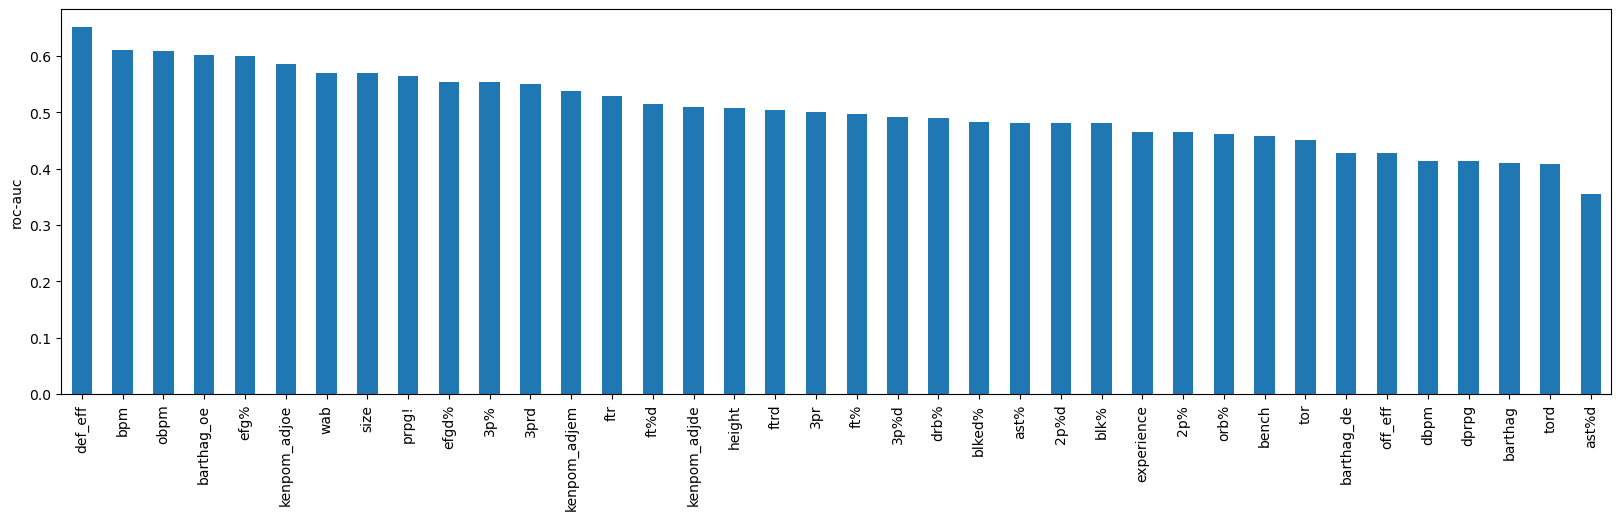

In [21]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [22]:
len(roc_values[roc_values > 0.6])

5

In [23]:
roc_values[roc_values > 0.6]

bpm          0.6109
obpm         0.6094
barthag_oe   0.6018
def_eff      0.6507
efg%         0.6003
dtype: float64

In [24]:
roc_values[roc_values > 0.57]

bpm            0.6109
obpm           0.6094
kenpom_adjoe   0.5852
barthag_oe     0.6018
def_eff        0.6507
efg%           0.6003
dtype: float64

In [25]:
roc_values[roc_values > 0.55]

wab            0.5691
prpg!          0.5650
bpm            0.6109
obpm           0.6094
kenpom_adjoe   0.5852
barthag_oe     0.6018
def_eff        0.6507
efg%           0.6003
efgd%          0.5544
3p%            0.5539
size           0.5691
dtype: float64

# III. XGBoost

In [128]:
X_train_scaled2 = X_train_scaled[[
'wab',
'bpm',
'obpm',
'kenpom_adjoe',
'def_eff',
'efg%',
'efgd%',
'size'
]]

X_test_scaled2 = X_test_scaled[[
'wab',
'bpm',
'obpm',
'kenpom_adjoe',
'def_eff',
'efg%',
'efgd%',
'size'
]]

In [129]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled2, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'colsample_bytree': 0.3, 'gamma': 0.4, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.4}


In [130]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    **best_params
)

best_xgb_model.fit(X_train_scaled2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [131]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.6299982954959925


In [132]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled2)
y_test_pred = best_xgb_model.predict(X_test_scaled2)

# Calculate accuracy scores
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {acc_train:.2f}")
print(f"F1 Score on Test Data: {acc_test:.2f}")

F1 Score on Training Data: 0.80
F1 Score on Test Data: 0.67


<Figure size 1000x600 with 0 Axes>

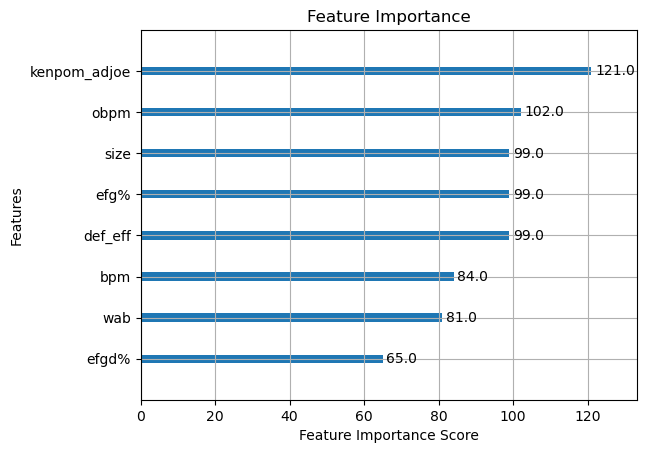

In [133]:
from xgboost import plot_importance

# Extract feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', show_values=True, xlabel='Feature Importance Score')
plt.title('Feature Importance')
plt.show()